In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [5]:
data_folder = 'data/'
data_file = '10101.csv'

In [6]:
df = pd.read_csv(data_folder + data_file)
df["time"] = df.index
df["day"] = df["time"] // 21600

mapping = {'w': 0, 'n': -1, 'r': 1}
df["state"] = df["state"].replace(mapping)
# keep only day 0

df = df[df["day"] == 0]
df["state"].value_counts()

 0    11680
-1     9104
 1      816
Name: state, dtype: int64

In [7]:
df1 = df.copy()
df1 = df1.drop(["rawState", "temp", "time", "day"], axis=1)
x = df1.drop(["state"], axis=1)
y = np.ravel(df1[["state"]])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=13)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [12]:
x_train

array([[-0.41988749, -0.21038763],
       [ 0.79506655, -0.22228317],
       [-0.53235378, -0.18542695],
       ...,
       [-0.44988168, -0.19480307],
       [ 0.48307869, -0.22688508],
       [ 0.48824694, -0.22688669]])

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

In [21]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(random_state=13)
# clf.fit(x_train, y_train)
# y_predict = clf.predict(x_test)

model = Sequential()
model.add(Dense(12, input_dim=2, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=5,
                    batch_size=10,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

y_predict = model.predict(x_test)

/home/matt989253/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

ValueError: in user code:

    File "/home/matt989253/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/matt989253/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/matt989253/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/matt989253/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/matt989253/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/home/matt989253/anaconda3/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/matt989253/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/matt989253/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/matt989253/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/matt989253/anaconda3/lib/python3.9/site-packages/keras/backend.py", line 5680, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((10, 3) vs (10, 1)).


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
cm = np.array(confusion_matrix(y_test, y_predict, labels=[0,-1,1], normalize='pred'))
confusion = pd.DataFrame(cm, index=['Wake', 'Non-Rem', 'Rem'], columns=['P Wake', 'P Non-Rem', 'P Rem'])
confusion

,P Wake,P Non-Rem,P Rem
Wake,0.545370,0.0,0.0
Non-Rem,0.416435,0.0,0.0
Rem,0.038194,0.0,0.0


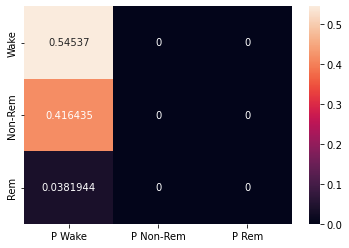

In [20]:
sns.heatmap(confusion,annot=True,fmt='g')
plt.show()

In [152]:
print(classification_report(y_test, y_predict, target_names=['Wake', 'Non-Rem', 'Rem'], zero_division=0))

              precision    recall  f1-score   support

        Wake       0.93      0.93      0.93      1799
     Non-Rem       0.95      0.96      0.95      2356
         Rem       0.29      0.23      0.26       165

    accuracy                           0.92      4320
   macro avg       0.72      0.71      0.71      4320
weighted avg       0.91      0.92      0.92      4320

